In [ ]:
# COLAB: uncomment below to setup for Git
# !git clone https://github.com/C7082-2022/labs-cv-colab

In [ ]:
# COLAB: uncomment below to change directory
# %cd labs-cv-colab/03-DL-basics

In [2]:
# setup for images
from IPython.display import Image

# Lab 05 Dropout and batch normalization


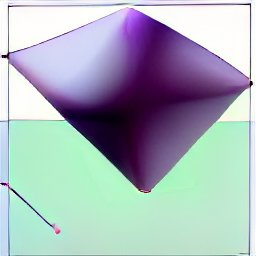

In [3]:
Image("img/craiyon-normal.jpg")
# Craiyon.com "Normalization" 

## 1 Objectives

There's more to the world of deep learning than just dense layers. There are dozens of kinds of layers you might add to a model. (Try browsing through the [Keras docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) for a sample!) Some are like dense layers and define connections between neurons, and others can do preprocessing or transformations of other sorts.

In this lesson, we'll learn about a two kinds of special layers, not containing any neurons themselves, but that add some functionality that can sometimes benefit a model in various ways. Both are commonly used in modern architectures.

## 2  Dropout

The first of these is the "dropout layer", which can help correct overfitting.

In the last lesson we talked about how overfitting is caused by the network learning spurious patterns in the training data. To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind **dropout**. To break up these conspiracies, we randomly *drop out* some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.

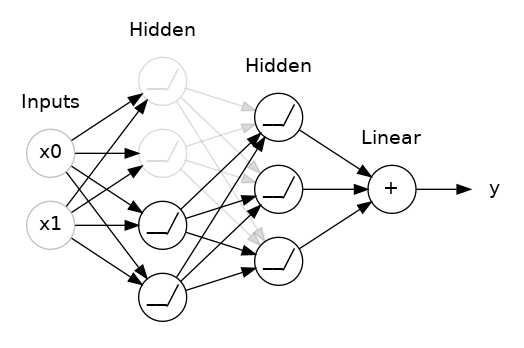

In [4]:
Image("img/5-1.gif", width = 600)
# An animation of a network cycling through various random dropout configurations


You could also think about dropout as creating a kind of *ensemble* of networks. The predictions will no longer be made by one big network, but instead by a committee of smaller networks. Individuals in the committee tend to make different kinds of mistakes, but be right at the same time, making the committee as a whole better than any individual. (If you're familiar with random forests as an ensemble of decision trees, it's the same idea.)



## 3 Adding Dropout

In Keras, the dropout rate argument `rate` defines what percentage of the input units to shut off. Put the `Dropout` layer just before the layer you want the dropout applied to:

```
keras.Sequential([
    # ...
    layers.Dropout(rate=0.3), # apply 30% dropout to the next layer
    layers.Dense(16),
    # ...
])
```

## 4 Batch Normalization

The next special layer we'll look at performs "batch normalization" (or "batchnorm"), which can help correct training that is slow or unstable.

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) or [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

Now, if it's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! In fact, we have a special kind of layer that can do this, the **batch normalization layer**. A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training.

## 5 Adding Batch Normalization 

It seems that batch normalization can be used at almost any point in a network. You can put it after a layer...

```
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),
```

... or between a layer and its activation function:

```
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

And if you add it as the first layer of your network it can act as a kind of adaptive preprocessor, standing in for something like Sci-Kit Learn's `StandardScaler`.

## 6 Example - Using Dropout and Batch Normalization

Let's continue developing the *Red Wine* model. Now we'll increase the capacity even more, but add dropout to control overfitting and batch normalization to speed up optimization. This time, we'll also leave off standardizing the data, to demonstrate how batch normalization can stabalize the training.

In [2]:

# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('data/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

<br>

When adding dropout, you may need to increase the number of units in your `Dense` layers.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

<br>

There's nothing to change this time in how we set up the training.

In [ ]:
# might need colab
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

## 7 Exercises

In this exercise, you'll add dropout to the *Spotify* data model and see how batch normalization can let you successfully train models on difficult datasets.

Run the next cell to get started!

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


<br>

First load the *Spotify* dataset.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


### 7.1 Add Dropout to Spotify Model

Here is a model: Add two dropout layers, one after the `Dense` layer with 128 units, and one after the `Dense` layer with 64 units. Set the dropout rate on both to `0.3`.

In [ ]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])



<br>

Now run this next cell to train the model see the effect of adding dropout.

In [ ]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

### 7.2 Evaluate Dropout

Remember this model tended to overfit the data around epoch 5. Did adding dropout seem to help prevent overfitting this time?

<br>

Now, we'll explore how batch normalization can fix problems in training.

Load the *Concrete* dataset. We won't do any standardization this time. This will make the effect of batch normalization much more apparent.

In [4]:
import pandas as pd

concrete = pd.read_csv('data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

<br>

Run the following cell to train the network on the unstandardized *Concrete* data.

Minimum Validation Loss: nan


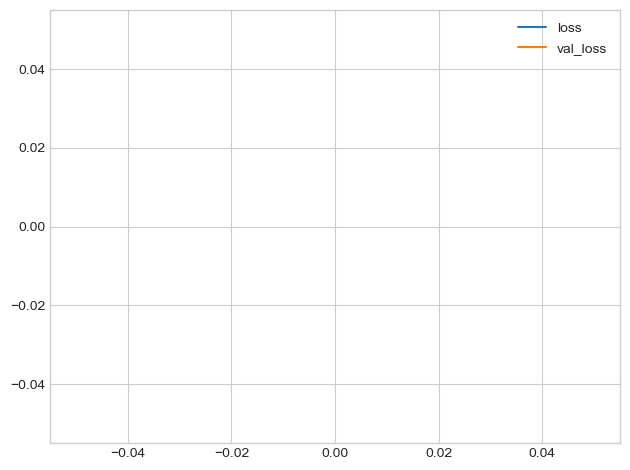

In [5]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

<br>

Did you end up with a blank graph? Trying to train this network on this dataset will usually fail. Even when it does converge (due to a lucky weight initialization), it tends to converge to a very large number.



### 7.3 Add Batch Normalization Layers

Batch normalization can help correct problems like this.

Add four `BatchNormalization` layers, one before each of the dense layers. (Remember to move the `input_shape` argument to the new first layer.)

In [ ]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])


<br>

Run the next cell to see if batch normalization will let us train the model.

In [ ]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

### 7.4 Evaluate Batch Normalization

Did adding batch normalization help?